In [2]:
# Install all required packages

%pip install transformers timm torchvision pillow --quiet


Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
import torch
import re
import json
import matplotlib.pyplot as plt
import os

In [5]:
# Load the fine-tuned Donut model and processor from HuggingFace
processor = DonutProcessor.from_pretrained("katanaml-org/invoices-donut-model-v1")
model = VisionEncoderDecoderModel.from_pretrained("katanaml-org/invoices-donut-model-v1")

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model is using {device.upper()}.")

Model is using CUDA.


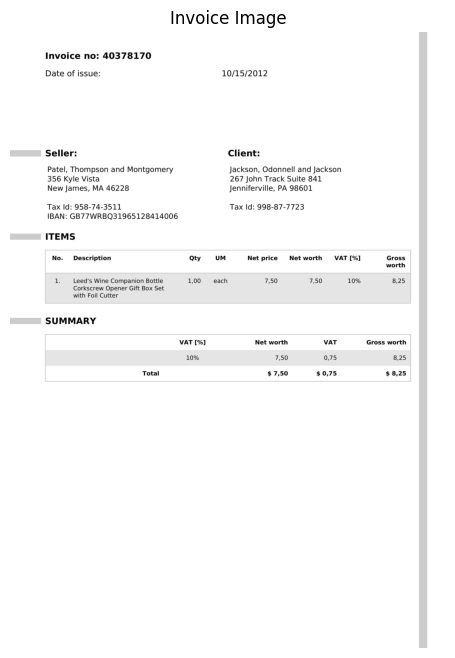

In [6]:
# Load invoice image
image_path = "C:/Users/P R E D A T O R/OneDrive/Desktop/OCR/Images/image1.jpg"

# Open and convert image to RGB (required for Donut)
image = Image.open(image_path).convert("RGB")

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Invoice Image")
plt.show()


In [7]:
# Preprocess the image for the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# Decoder input: start-of-sequence token
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
decoder_input_ids = decoder_input_ids.to(device)

# Run inference with Donut model
with torch.no_grad():
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=1024,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id
    )

# Decode the output text
raw_output = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()

# Show the raw output
print("Raw Donut Output:\n")
print(raw_output)


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Raw Donut Output:

<s_cord-v2><s_header><s_invoice_no> 40378170</s_invoice_no><s_invoice_date> 10/15/2012</s_invoice_date><s_seller> Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228</s_seller><s_client> Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client><s_seller_tax_id> 958-74-3511</s_seller_tax_id><s_client_tax_id> 998-87-7723</s_client_tax_id><s_iban> GB77WRBQ31965128414006</s_iban></s_header><s_items><s_item_desc> Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc><s_item_qty> 1,00</s_item_qty><s_item_net_price> 7,50</s_item_net_price><s_item_net_worth> 7,50</s_item_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 8,25</s_item_gross_worth></s_items><s_summary><s_total_net_worth> $7,50</s_total_net_worth><s_total_vat> $0,75</s_total_vat><s_total_gross_worth> $8,25</s_total_gross_worth></s_summary>


In [8]:
def clean_donut_output(text):
    """
    Cleans up common Donut model errors such as:
    - Junk before first tag
    - Removing whitespaces
    """

    # Remove junk before first tag
    text = re.sub(r"^[^<]*", "", text)

    # Remove repeated commas (2 or more), keep single commas
    text = re.sub(r",+", ",", text)

    # Collapse whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()


# Clean the raw Donut output
cleaned_output = clean_donut_output(raw_output)

# Display the cleaned result
print("Cleaned Donut Output:\n")
print(cleaned_output)


Cleaned Donut Output:

<s_cord-v2><s_header><s_invoice_no> 40378170</s_invoice_no><s_invoice_date> 10/15/2012</s_invoice_date><s_seller> Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228</s_seller><s_client> Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client><s_seller_tax_id> 958-74-3511</s_seller_tax_id><s_client_tax_id> 998-87-7723</s_client_tax_id><s_iban> GB77WRBQ31965128414006</s_iban></s_header><s_items><s_item_desc> Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc><s_item_qty> 1,00</s_item_qty><s_item_net_price> 7,50</s_item_net_price><s_item_net_worth> 7,50</s_item_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 8,25</s_item_gross_worth></s_items><s_summary><s_total_net_worth> $7,50</s_total_net_worth><s_total_vat> $0,75</s_total_vat><s_total_gross_worth> $8,25</s_total_gross_worth></s_summary>


In [9]:
def parse_tags_to_dict(text):
    """
    Parses cleaned Donut output containing <s_field>value</s_field> pairs into a dictionary.
    Supports repeated fields like <s_item>.
    """
    pattern = r"<(s_[a-zA-Z0-9_]+)>(.*?)</\1>"
    matches = re.findall(pattern, text)
    
    parsed = {}
    for tag, value in matches:
        value = value.strip()
        if tag in parsed:
            if isinstance(parsed[tag], list):
                parsed[tag].append(value)
            else:
                parsed[tag] = [parsed[tag], value]
        else:
            parsed[tag] = value
    return parsed


# Parse the cleaned output into structured fields
parsed_output = parse_tags_to_dict(cleaned_output)

# Display the JSON result
print("Parsed JSON Output:\n")
print(json.dumps(parsed_output, indent=2))


Parsed JSON Output:

{
  "s_header": "<s_invoice_no> 40378170</s_invoice_no><s_invoice_date> 10/15/2012</s_invoice_date><s_seller> Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228</s_seller><s_client> Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client><s_seller_tax_id> 958-74-3511</s_seller_tax_id><s_client_tax_id> 998-87-7723</s_client_tax_id><s_iban> GB77WRBQ31965128414006</s_iban>",
  "s_items": "<s_item_desc> Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc><s_item_qty> 1,00</s_item_qty><s_item_net_price> 7,50</s_item_net_price><s_item_net_worth> 7,50</s_item_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 8,25</s_item_gross_worth>",
  "s_summary": "<s_total_net_worth> $7,50</s_total_net_worth><s_total_vat> $0,75</s_total_vat><s_total_gross_worth> $8,25</s_total_gross_worth>"
}


In [10]:
def extract_nested_tags(text):
    top_level_tags = re.findall(r"<(s_[^>]+)>(.*?)</\1>", text, re.DOTALL)
    result = {}
    for section_tag, section_content in top_level_tags:
        inner_tags = re.findall(r"<(s_[^>]+)>(.*?)</\1>", section_content, re.DOTALL)
        for key, value in inner_tags:
            value = value.strip()
            if key in result:
                if isinstance(result[key], list):
                    result[key].append(value)
                else:
                    result[key] = [result[key], value]
            else:
                result[key] = value
    return result

parsed_output = extract_nested_tags(raw_output)

print("Parsed Tags:\n")
print(json.dumps(parsed_output, indent=2))


Parsed Tags:

{
  "s_invoice_no": "40378170",
  "s_invoice_date": "10/15/2012",
  "s_seller": "Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228",
  "s_client": "Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601",
  "s_seller_tax_id": "958-74-3511",
  "s_client_tax_id": "998-87-7723",
  "s_iban": "GB77WRBQ31965128414006",
  "s_item_desc": "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter",
  "s_item_qty": "1,00",
  "s_item_net_price": "7,50",
  "s_item_net_worth": "7,50",
  "s_item_vat": "10%",
  "s_item_gross_worth": "8,25",
  "s_total_net_worth": "$7,50",
  "s_total_vat": "$0,75",
  "s_total_gross_worth": "$8,25"
}


In [11]:

def build_structured_json(parsed):
    """
    Converts nested <s_*> fields inside header, items, and summary into
    a clean JSON format matching the ground truth schema.
    """

    return {
        "header": {
            "invoice_no": parsed.get("s_invoice_no"),
            "invoice_date": parsed.get("s_invoice_date"),
            "seller": parsed.get("s_seller"),
            "client": parsed.get("s_client"),
            "seller_tax_id": parsed.get("s_seller_tax_id"),
            "client_tax_id": parsed.get("s_client_tax_id"),
            "iban": parsed.get("s_iban"),
        },
        "items": [{
        "item_desc": parsed.get("s_item_desc"),
        "item_qty": parsed.get("s_item_qty"),
        "item_net_price": parsed.get("s_item_net_price"),
        "item_net_worth": parsed.get("s_item_net_worth"),
        "item_vat": parsed.get("s_item_vat"),
        "item_gross_worth": parsed.get("s_item_gross_worth"),  
        }],
        "summary": {
            "total_net_worth": parsed.get("s_total_net_worth"),
            "total_vat": parsed.get("s_total_vat"),
            "total_gross_worth": parsed.get("s_total_gross_worth"),
        }
    }

# Build final structured JSON
structured_json = build_structured_json(parsed_output)

# Print result

print("Final Structured JSON:\n")
print(json.dumps(structured_json, indent=2))


Final Structured JSON:

{
  "header": {
    "invoice_no": "40378170",
    "invoice_date": "10/15/2012",
    "seller": "Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228",
    "client": "Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601",
    "seller_tax_id": "958-74-3511",
    "client_tax_id": "998-87-7723",
    "iban": "GB77WRBQ31965128414006"
  },
  "items": [
    {
      "item_desc": "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter",
      "item_qty": "1,00",
      "item_net_price": "7,50",
      "item_net_worth": "7,50",
      "item_vat": "10%",
      "item_gross_worth": "8,25"
    }
  ],
  "summary": {
    "total_net_worth": "$7,50",
    "total_vat": "$0,75",
    "total_gross_worth": "$8,25"
  }
}


In [12]:
# Create output directory if it doesn't exist
output_dir = "../Parsed JSON Output"
os.makedirs(output_dir, exist_ok=True)

# Use image filename as base for output JSON
image_filename = os.path.basename(image_path)
image_basename = os.path.splitext(image_filename)[0]

# Final JSON path
output_filename = f"{image_basename}.json"
output_path = os.path.join(output_dir, output_filename)

# Clean up display path for print
display_path = output_path.replace("../", "")

# Function to compare two JSON objects
def jsons_are_equal(json1, json2):
    return json.dumps(json1, sort_keys=True) == json.dumps(json2, sort_keys=True)

# Check and save/overwrite if needed
if not os.path.exists(output_path):
    with open(output_path, "w") as f:
        json.dump(structured_json, f, indent=2)
    print(f"JSON saved to: {display_path}")
else:
    with open(output_path, "r") as f:
        existing_json = json.load(f)

    if not jsons_are_equal(existing_json, structured_json):
        with open(output_path, "w") as f:
            json.dump(structured_json, f, indent=2)
        print(f"JSON updated at: {display_path}")
    else:
        print(f"No changes detected. File already exists at: {display_path}")


No changes detected. File already exists at: Parsed JSON Output\image1.json


In [13]:
def compare_fields(gt, pred):
    mismatches = []
    correct = 0
    total = 0

    def compare_dict(gt_d, pred_d, prefix=""):
        nonlocal correct, total
        for key in gt_d:
            total += 1
            full_key = f"{prefix}.{key}" if prefix else key
            gt_val = gt_d[key]
            pred_val = pred_d.get(key, None)
            if gt_val == pred_val:
                correct += 1
            else:
                mismatches.append((full_key, gt_val, pred_val))

    compare_dict(gt_parse["header"], structured_json["header"], "header")
    compare_dict(gt_parse["summary"], structured_json["summary"], "summary")
    compare_dict({"items": gt_parse["items"]}, {"items": structured_json["items"]}, "items")

    return correct, total, mismatches

# Load matching ground truth JSON file
with open("C:/Users/P R E D A T O R/OneDrive/Desktop/OCR/Validate/ground_truth_for_image1.json", "r") as f:
    gt_parse = json.load(f)

# extract inner structure if needed
if "parse" in gt_parse:
    gt_parse = gt_parse["parse"]
elif "gt_parse" in gt_parse:
    gt_parse = gt_parse["gt_parse"]


## Evaluation metrics

1. Exact Match
2. BLEU Score
3. Field Level Accuracy


In [14]:
# Exact match
# Compare with ground truth with extracted JSON for header, items and summary fields

exact_match = structured_json["header"] == gt_parse["header"]
print(" Exact Match for header field:", exact_match)
exact_match = structured_json["items"][0] == gt_parse["items"][0]
print(" Exact Match for items:", exact_match)
exact_match = structured_json["summary"] == gt_parse["summary"]
print(" Exact Match for summary:", exact_match)


 Exact Match for header field: False
 Exact Match for items: True
 Exact Match for summary: True


In [15]:
# Compare with ground truth calculating BLEU score

smoothie = SmoothingFunction().method4

def bleu_score(gt: str, pred: str) -> float:
    """
    Computes the BLEU score between a ground truth string and a prediction.

    Args:
        gt (str): Ground truth sentence.
        pred (str): Predicted sentence.

    Returns:
        float: BLEU score (0.0 if either input is empty).
    """
    if not gt or not pred:
        return 0.0
    return sentence_bleu([gt.split()], pred.split(), smoothing_function=smoothie)


In [16]:
# Compare with ground truth calculating BLEU score for specific fields

# Fields to evaluate with BLEU score
bleu_fields = ["seller", "client", "iban", "item_desc"]

for field in bleu_fields:
    try:
        if field == "item_desc":
            gt_val = gt_parse["items"][0]["item_desc"]
            pred_val = structured_json["items"][0]["item_desc"]
        else:
            gt_val = gt_parse["header"][field]
            pred_val = structured_json["header"][field]

        score = bleu_score(gt_val, pred_val)
        print(f'BLEU score for "{field}": {score:.2f}')
    except (IndexError, KeyError, TypeError):
        print(f' - "{field}": Not available.')


BLEU score for "seller": 0.89
BLEU score for "client": 1.00
BLEU score for "iban": 1.00
BLEU score for "item_desc": 1.00


In [17]:

def normalize_price(value: str | int) -> float:
    """
    Normalize a price string by removing non-numeric characters and converting to float.

    This function:
    - Removes any characters except digits and punctuation.
    - Converts commas to dots (to handle European decimal formats).
    - Casts the cleaned string to a float.

    Args:
        value (str or number): The input price as a string or numeric value.

    Returns:
        float: Normalized numeric price value.
    """
    cleaned = re.sub(r"[^\d,\.]", "", str(value)).replace(",", ".")
    return float(cleaned)


In [18]:
# Evaluation metrics; Field-Level Accuracy with Tolerance-Based Comparison

def score_field(gt, pred, field_type="text", tolerance=0.01):
    """
    Computes the similarity score between ground truth and predicted values
    based on field type.

    Args:
        pred (float): Predicted value.
        gt (float): Ground truth value.
        field_type (str): Either "text" or "numeric".
        tolerance (float): Acceptable relative error (e.g., 0.01 = 1%).

    Returns:
        float: 1.0/0.0 for numeric match within tolerance.
    """

    if field_type == "text":
        return bleu_score(gt, pred)
    elif field_type == "numeric":
        try:
            gt_val = normalize_price(gt)
            pred_val = normalize_price(pred)
            return (
                1.0
                if abs(gt_val - pred_val) <= tolerance * max(abs(gt_val), 1.0)
                else 0.0
            )
        except:
            return 0.0


In [19]:
# Define which fields to evaluate
text_fields = {
    "header.invoice_no": ("header", "invoice_no"),
    "header.invoice_date": ("header", "invoice_date"),
    "header.seller": ("header", "seller"),
    "header.client": ("header", "client"),
    "header.seller_tax_id": ("header", "seller_tax_id"),
    "header.client_tax_id": ("header", "client_tax_id"),
    "header.iban": ("header", "iban"),
    "items[0].item_desc": ("items", "item_desc"),
}

numeric_fields = {
    "summary.total_net_worth": ("summary", "total_net_worth"),
    "summary.total_vat": ("summary", "total_vat"),
    "summary.total_gross_worth": ("summary", "total_gross_worth"),
    "items[0].item_qty": ("items", "item_qty"),
    "items[0].item_net_price": ("items", "item_net_price"),
    "items[0].item_net_worth": ("items", "item_net_worth"),
    "items[0].item_gross_worth": ("items", "item_gross_worth"),
}


In [20]:
mismatches = []
correct = 0
total = 0

def safe_get(d, section, key):
    try:
        if section == "items":
            return d.get(section, [{}])[0].get(key)
        else:
            return d.get(section, {}).get(key)
    except Exception:
        return None

# Evaluate text fields
for label, (section, key) in text_fields.items():
    gt_val = safe_get(gt_parse, section, key)
    pred_val = safe_get(structured_json, section, key)

    score = score_field(gt_val, pred_val, field_type="text")
    total += 1
    if score >= 1.0:
        correct += 1
    else:
        mismatches.append((label, gt_val, pred_val))

# Evaluate numeric fields
for label, (section, key) in numeric_fields.items():
    gt_val = safe_get(gt_parse, section, key)
    pred_val = safe_get(structured_json, section, key)

    score = score_field(gt_val, pred_val, field_type="numeric", tolerance=0.05)
    total += 1
    if score >= 1.0:
        correct += 1
    else:
        mismatches.append((label, gt_val, pred_val))

# Final reporting
accuracy = (correct / total) * 100 if total else 0
print(f"\nTotal Field-Level Accuracy: {correct}/{total} ({accuracy:.2f}%)")

if mismatches:
    print("\nMismatches:")
    for label, gt, pred in mismatches:
        print(f' - "{label}":\n    Ground truth: {gt}\n    Prediction: {pred}')
else:
    print("All fields matched.")



Total Field-Level Accuracy: 14/15 (93.33%)

Mismatches:
 - "header.seller":
    Ground truth: Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228
    Prediction: Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 45228
